开始训练...
Epoch 0, Loss: 4878.3828125
Epoch 1000, Loss: 88.4515151977539
Epoch 2000, Loss: 62.76615905761719
Epoch 3000, Loss: 9.407642364501953
Epoch 4000, Loss: 0.9186469316482544
Epoch 5000, Loss: 0.14000600576400757
Epoch 6000, Loss: 0.04243173450231552
Epoch 7000, Loss: 0.12672007083892822
Epoch 8000, Loss: 0.266695111989975
Epoch 9000, Loss: 0.02279633656144142
训练完成!
相对误差: 0.64%


E:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\lib\site-packages\IPython\core\pylabtools.p

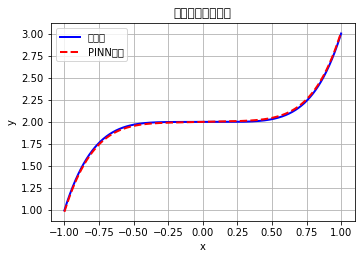

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

# Set random seed for reproducible results
torch.manual_seed(42)
np.random.seed(42)

# Define neural network model
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()  # Use Tanh activation function
        
        # Build fully connected neural network
        self.linears = nn.ModuleList()
        for i in range(len(layers)-1):
            self.linears.append(nn.Linear(layers[i], layers[i+1]))
            
    def forward(self, x):
        # Convert input to float tensor
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        
        # Forward propagation
        for i in range(len(self.linears)-1):
            x = self.activation(self.linears[i](x))
        x = self.linears[-1](x)
        return x

# Define physics-informed loss function
def physics_loss(model, x):
    """
    Compute physics-informed loss, i.e., residual of the differential equation
    """
    # Set requires_grad=True to compute gradients
    x.requires_grad = True
    
    # Compute network output
    y = model(x)
    
    # Compute first derivative
    dy_dx = grad(y, x, torch.ones_like(y), create_graph=True)[0]
    
    # Compute second derivative
    d2y_dx2 = grad(dy_dx, x, torch.ones_like(dy_dx), create_graph=True)[0]
    
    # Compute third derivative
    d3y_dx3 = grad(d2y_dx2, x, torch.ones_like(d2y_dx2), create_graph=True)[0]
    
    # Compute fourth derivative
    d4y_dx4 = grad(d3y_dx3, x, torch.ones_like(d3y_dx3), create_graph=True)[0]
    
    # Compute differential equation residual: d^4y/dx^4 - 120x
    residual = d4y_dx4 - 120 * x
    
    # Return mean squared error
    return torch.mean(residual**2)

# Define boundary condition loss function
def boundary_loss(model):
    """
    Compute boundary condition loss
    """
    # Left boundary point x = -1
    x_left = torch.tensor([[-1.0]], requires_grad=True)
    y_left = model(x_left)
    dy_dx_left = grad(y_left, x_left, torch.ones_like(y_left), create_graph=True)[0]
    
    # Right boundary point x = 1
    x_right = torch.tensor([[1.0]], requires_grad=True)
    y_right = model(x_right)
    dy_dx_right = grad(y_right, x_right, torch.ones_like(y_right), create_graph=True)[0]
    
    # Compute boundary condition loss
    # y(-1) = 1, y'(-1) = 5, y(1) = 3, y'(1) = 5
    loss_bc = (y_left - 1)**2 + (dy_dx_left - 5)**2 + (y_right - 3)**2 + (dy_dx_right - 5)**2
    
    return loss_bc

# Define training function
def train_pinn(model, epochs, lr):
    """
    Train PINN model
    """
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Record loss history
    loss_history = []
    
    # Generate training points
    x_train = torch.linspace(-1, 1, 1000).view(-1, 1)
    
    # Training loop
    for epoch in range(epochs):
        # Zero gradients
        optimizer.zero_grad()
        
        # Compute physics-informed loss
        loss_physics = physics_loss(model, x_train)
        
        # Compute boundary condition loss
        loss_bc = boundary_loss(model)
        
        # Total loss
        loss = loss_physics + loss_bc
        
        # Backward propagation
        loss.backward()
        optimizer.step()
        
        # Record loss
        loss_history.append(loss.item())
        
        # Print loss every 1000 iterations
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return loss_history

# Define analytical solution for comparison
def analytical_solution(x):
    return x**5 + 2


# Set network architecture
layers = [1, 20, 20, 20, 1]  # Input layer, 3 hidden layers, output layer

# Create model
model = PINN(layers)

# Training parameters
epochs = 10000
learning_rate = 0.001

# Train model
print("Starting training...")
loss_history = train_pinn(model, epochs, learning_rate)
print("Training completed!")

# Test model
x_test = torch.linspace(-1, 1, 1000).view(-1, 1)
y_pred = model(x_test).detach().numpy()
y_true = analytical_solution(x_test.numpy())

# Compute relative error
relative_error = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
print(f"Relative error: {relative_error*100:.2f}%")


import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# Plot results
plt.figure(figsize=(12, 8))

# Plot predicted solution and analytical solution
plt.subplot(2, 2, 1)
plt.plot(x_test.numpy(), y_true, 'b-', linewidth=2, label='Analytical Solution')
plt.plot(x_test.numpy(), y_pred, 'r--', linewidth=2, label='PINN Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Differential Equation Solutions')
plt.legend()
plt.grid(True)

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_exact = y_true.reshape(-1, 1)
y_p_pinn = y_pred
y_true = y_exact
R2_pinn = r2_score(y_p_pinn, y_true)
mae_pinn = mean_absolute_error(y_p_pinn, y_true)
rmse_pinn = mean_squared_error(y_p_pinn, y_true, squared=False)
inf_norm_pinn = np.linalg.norm(y_p_pinn - y_true, ord = np.inf)

print(f"R2_pinn: {R2_pinn}, mae_pinn: {mae_pinn}, rmse_pinn: {rmse_pinn}, inf_norm_pinn: {inf_norm_pinn}")

R2_pinn: 0.9981247064216378, mae_pinn: 0.012358017265796661, rmse_pinn: 0.013540714047849178, inf_norm_pinn: 0.0179593563079834


In [3]:
import numpy as np
import pandas as pd

data_to_save = pd.DataFrame({
    'x': x_test.flatten(),
    'y_pred_pinn': y_p_pinn.flatten(),
    'y_exact': y_true.flatten()
})

data_to_save.to_csv('pinn_16.csv', index=False)
print(" pinn_16.csv")

数据已保存至 pinn_16.csv
